In [3]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html 
# Install required libraries
# Import required libraries
import random
import math
import gymnasium as gym
from gymnasium import spaces
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

print(device)

cuda


In [4]:
# imports are always needed
import torch


# get index of currently selected device
torch.cuda.current_device() # returns 0 in my case


# get number of GPUs available
torch.cuda.device_count() # returns 1 in my case


# get the name of the device
torch.cuda.get_device_name(0) # good old Tesla K80


'NVIDIA GeForce RTX 4070 Laptop GPU'

In [28]:

# modify this to fit current environment 
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
class DQN(nn.Module):

    def __init__(self, obs, action):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(obs, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, action)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
class agent():
    def __init__(self,obs,actions):
        self.actions = actions
        self.batch = 128
        self.discount_factor = 0.99
        self.eps = 1
        self.eps_decay = 0.9954
        # self.tau = 0.005
        self.learning_rate = 0.1
        self.memory = ReplayMemory(5000) # replay memory 
        self.policy_net = DQN(obs, actions).to(device) # action value function
        self.target_net = DQN(obs, actions).to(device) # target action value function 
    
    def select_action(self,state):
        p = random.random()
        if p < self.eps:
            #random action
            action = np.random.choice(self.actions)
            return torch.tensor(action, device=device)
        else:
            #best action
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1).indices.view(1, 1)
    def update(self,timestep,episode,terminated):
        #update weight every 5 steps
        if timestep+1%5 == 0:
            #sample and train policy_net
            self.replay()
        #update target_net every 5 eps, If solved, set as target_net
        if episode+1%5 == 0 or terminated == True:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        return self.target_net, self.policy_net
    
    def replay(self):
        if self.memory.len() < self.batch:
            return
        else:
            sample = self.memory.sample(self.batch)
            print("sample",sample)
            q_values_list = []
            target_list = []
            for state, action, next_state, reward in sample:
                if next_state == None:
                    target = reward
                else:
                    with torch.no_grad:
                        #predict target Q-values
                        next_q = self.target_net(next_state).max(1).indices.view(1,1).item() #predict next state with target network 
                        target = (reward + self.discount_factor * np.amax(next_q))
                q_values = self.policy_net(state)??? #predict with policy network
            loss = nn.MSELoss(q_values_list,target_list)
            #backprop     

            return self.policy_net
        #replay algorithim here
env = gym.make("CartPole-v1")
state, info = env.reset()
obs = len(state)
actions = env.action_space.n
agent = agent(obs,actions)
        
    

In [8]:

actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
obs = len(state)
# agent = agent(obs,actions)
torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
m = deque([], maxlen=5)
m.append(1)
len(m)

1

tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
fell
loop end now
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
fell
loop end now
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
fell
loop end now
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], de

<Figure size 640x480 with 0 Axes>

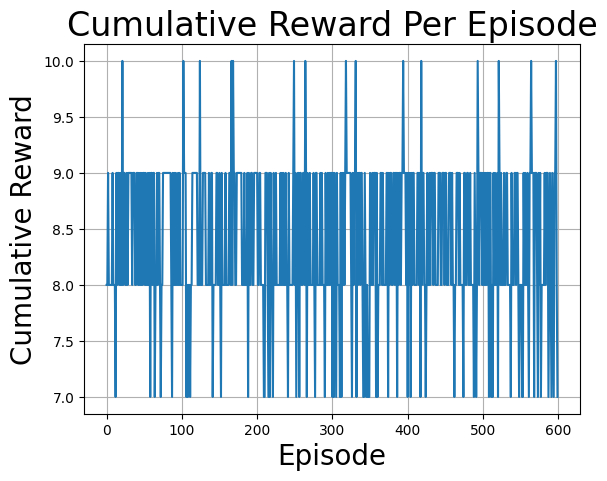

In [34]:
#create environment to run DQN
env = gym.make("CartPole-v1")

max_episodes = 600
max_timestep = 500
state, info = env.reset()
obs = len(state)
actions = env.action_space.n
# agent = agent(obs,actions)
reward_per_episode = []
for episode in range(max_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    terminated,truncated = False, False
    for timestep in range(500):
        action = agent.select_action(state)
        print(action)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        if terminated ==True:
            if truncated == False:
                reward = -10
        if terminated:
            print('fell')
            next_state = None #used to check if object has fallen during replay
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        agent.update(timestep=timestep,episode=episode,terminated=truncated) #update network weights
        if terminated or truncated: # close loop if it ends
            print('loop end now')
            reward_per_episode.append(timestep)
            break
    agent.eps = agent.eps * agent.eps_decay #eps decay

print('solved',truncated)
print(reward_per_episode)
plt.figure()
fig ,  ax = plt.subplots()
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Cumulative Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode', fontsize=24)
ax.plot(reward_per_episode,linestyle='solid',label = 'Q learning')
plt.grid()
plt.show()

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()